# Audio Classification Using Edge Impulse

## Introduction

This example uses audio input from fast analog input IN2 and uses local Edge Impulse Classification to classigy 5 seconds of audio.

This is based on the Edge Immpulse example:
https://github.com/edgeimpulse/linux-sdk-python/blob/master/examples/audio/classify.py 

To setup the Red Pitaya see the audio-classification-from-file.ipynb notebook introduction.


In [1]:
from redpitaya.overlay.mercury import mercury as overlay

import IPython.display as ipd
import matplotlib.pyplot as plt

#Audio processing requirements
import os
import sys, getopt
import signal
import numpy as np
from scipy.io import wavfile

#Edge Impulse requirements
import json
import time, hmac, hashlib
import requests
import re, socket
import math
from edge_impulse_linux.runner import ImpulseRunner

fpga = overlay()

Check FPGA [OK].


In [2]:
in2 = fpga.osc(1, 1.0)
# data rate decimation 
in2.decimation = 41667 #125 Msps / 41667 = 30 Ksps

# trigger timing [sample periods]
N = in2.buffer_size
in2.trigger_pre  = 0
in2.trigger_post = N

# disable hardware trigger sources - the Jupyter notebook will trigger the start of audio recording
in2.trig_src = 0

In [3]:
def record_audio():
    # synchronization and trigger sources are the default,
    # which is the module itself
    in2.reset()
    in2.start()
    in2.trigger()
    print ('Recording started')
    # wait for data
    while (in2.status_run()): pass
    print ('Recording complete')
    data = in2.data(N)
    return data[1:] #Remove first sample as it maybe 

def save_audio(audio_data, file='float_wave_test_raw.wav', sr = 3000): #default sample rate 3 Ksps
    wavfile.write(file, sr, audio_data)

In [4]:
runner = None
model_file_name = 'modelfile.eim'
audio_file_name = 'float_wave_test_raw.wav'

dir_path = os.path.dirname(os.path.realpath(model_file_name))
modelfile = os.path.join(dir_path, model_file_name)
audio_file = os.path.join(dir_path, audio_file_name)

In [5]:
samplerate, generator = wavfile.read(audio_file)

features = np.array([], dtype=np.int16)
runner = ImpulseRunner(modelfile)

model_info = runner.init()
labels = model_info['model_parameters']['labels']
window_size = model_info['model_parameters']['input_features_count']
sampling_rate = model_info['model_parameters']['frequency']
deploy_version = model_info['project']['deploy_version']

print('Loaded runner for "' + model_info['project']['owner'] + ' / ' + model_info['project']['name'] + '"')
print('labels: ', labels)
print('deploy_version: ', deploy_version)

Loaded runner for "M0JPI / Sound Test"
labels:  ['background-noise', 'edge-impulse', 'red-pitaya']
deploy_version:  16


## Recording the Audio and Classifying it

In [10]:
#Record Audio
audio_data_returned = record_audio()
save_audio(audio_data_returned, sr = 3000)

#Classify Audio
samplerate, generator = wavfile.read(audio_file)
features = np.array([], dtype=np.int16) #Reset features
features = np.concatenate((features, generator), axis=0)

#Reset the runner
runner = None
runner = ImpulseRunner(modelfile)
model_info = runner.init()
res = runner.classify(features[:window_size].tolist())

#Show the classification key that has the highest confidence index
best_label = max(res['result']['classification'], key=lambda key: res['result']['classification'][key])
confidence = res['result']['classification'][best_label]

#Print time to infer and the best label and confidence
print('Result (%d ms.) ' % (res['timing']['dsp'] + res['timing']['classification']), end='')
print(best_label,"{:.2%}".format(confidence))

Recording started
Recording complete
Result (26 ms.) background-noise 100.00%


## Classification Detailed Results

In [8]:
res

{'result': {'classification': {'background-noise': 0.8552300930023193,
   'edge-impulse': 0.06903357058763504,
   'red-pitaya': 0.07573632895946503}},
 'timing': {'anomaly': 0,
  'classification': 2,
  'dsp': 37,
  'json': 16,
  'stdin': 37}}

In [9]:
print('Result (%d ms.) ' % (res['timing']['dsp'] + res['timing']['classification']), end='')
for label in labels:
    score = res['result']['classification'][label]
    print('%s: %.2f\t' % (label, score), end='')
    print('', flush=True)

Result (39 ms.) background-noise: 0.86	
edge-impulse: 0.07	
red-pitaya: 0.08	


## Display the Data Waveform

In [11]:
#Define the functions
def display_audio(audio_data,sr = 3000): #default sample rate 3 Ksps
    return ipd.Audio(audio_data, rate=sr) # load a NumPy array

def plot_audio(audio_data):
    # show the part of the buffer requested by pre/post trigger timing - in this example the whole buffer.
    plt.plot(audio_data_returned)
    plt.show()

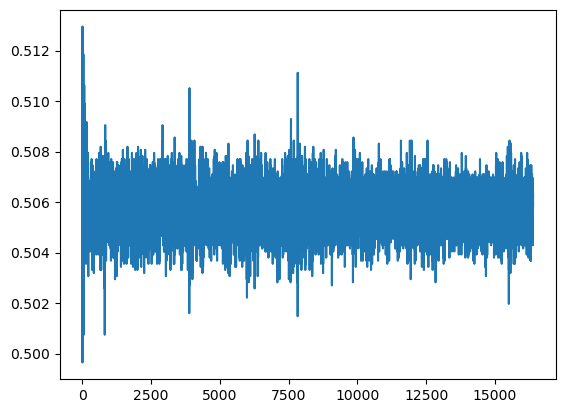

In [12]:
#Use the functions
plot_audio(audio_data_returned)
python_display_audio = display_audio(audio_data_returned, sr = 3000)
python_display_audio